In [1]:
from coal_mapper import *
import kmapper as km

import plotly.express as px
from sklearn.decomposition import PCA

### import data – made from the dataset_creation

In [2]:
all = pd.read_excel("WHOLE2.xlsx")

### manipulate data + create new variables to better view relationships in the mapper

In [3]:
def manipulate (all):
    all['Year'] = all['Year'].astype(int)
    all['OperatingYear'] = all['OperatingYear'].astype(int)
    all['AverageAge'] = all['AverageAge'].fillna(-5)

    def addAge(id):
        id['PlantAge'] = id['Year'] - id['OperatingYear']
        new = id[id['PLNGENAN'] > 0]
        new = id[id['PlantAge'] > 0]
        return new
    all = addAge(all)
    all.loc[all['AverageAge'] != -5, ['PlantAge']] = all['AverageAge']
    all = all.drop(columns = "AverageAge")
    all = all.reset_index().drop(["index"], axis=1)
    def killOutliars(id):
        if (id > 2.1):
            return 2.1
        else:
            return id
    def distance_CarbonIntensity(id):
        id['CarbonIntensity'] = id['CarbonIntensity'].apply(killOutliars)
        id['CarbonIntensity'] = 7**(id['CarbonIntensity'])
        return id
    all = distance_CarbonIntensity(all)
    
    return all

all = manipulate(all)

/Users/gathrid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [4]:
all.head()

,Year,PSTATABB,ORISPL,LAT,LON,label,CAPFAC,PLNGENAN,PLCO2AN,PLNOXAN,...,CO2limits,CO2limitsOppose,fundrenewablesOppose,regulateOppose,reducetaxOppose,RenewableReplacement,%lessThanCoal,numGenerators,OperatingYear,PlantAge
0,2010,MN,50252.0,45.618300,-94.200500,"2010: International Paper Sartell Mill, MN",0.43680,113643.000,61070.1956,196.4350,...,61.830,37.636,15.032,28.393,38.867,-1,NaN,NaN,1930,80.0
1,2014,MI,10149.0,45.062836,-83.423333,"2014: Decorative Panels Intl, MI",0.74300,48796.000,20809.1820,24.9890,...,61.483,37.908,14.516,27.768,38.423,-1,NaN,NaN,1946,68.0
2,2020,WV,10151.0,39.561831,-80.163138,"2020: Grant Town Power Plant, WV",0.73686,617730.000,833260.7190,1330.9330,...,60.001,39.570,15.207,28.022,37.853,1,-0.363866,1.0,1946,27.0
3,2016,FL,10202.0,30.681823,-81.455413,"2016: Fernandina Beach Mill, FL",0.70956,660115.020,113378.2430,176.8120,...,56.207,43.731,15.799,29.636,41.984,-1,NaN,NaN,1946,70.0
4,2010,MO,10207.0,39.426100,-91.025800,"2010: Ashland Inc, MO",0.37730,56851.681,32438.5547,148.0728,...,58.503,40.902,17.080,30.761,38.742,-1,NaN,NaN,1946,64.0


### add coal plant retrofit cost data – data from EIA form 860: EnviroEquip data file

In [5]:
def addRetrofitData(all):
    pC = pd.read_excel('enviroEquipt.xlsx')
    pC2 = pC.replace({' ': 0})
    pC2 = pC2.fillna(0)
    
    pC2['Inservice Year'] = pC2['Inservice Year'].astype(int)
    pC2['Total Cost (Thousand Dollars)'] = pC2['Total Cost (Thousand Dollars)'].astype(int)

    def retrofit(id):
        if id>2004:
            return 1
        else:
            return 0

    pC2['post2004Retrofit'] = pC2['Inservice Year'].apply(retrofit)

    pC = pC2[pC2['Inservice Year'] > 2004]

    pC2 = pC.groupby('Plant Code')['Total Cost (Thousand Dollars)', 'post2004Retrofit'].sum().reset_index() 
    pC2['post2004RetrofitCosts'] = pC2['Total Cost (Thousand Dollars)']*1000
    pC2 = pC2.rename(columns={"Plant Code": 'ORISPL'})

    all = all.merge(pC2, how='left', left_on='ORISPL', right_on='ORISPL')
    all = all.fillna(0)
    del all["Total Cost (Thousand Dollars)"]
    
    return all

all = addRetrofitData(all)

<ipython-input-5-fd8421163bcf>:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pC2 = pC.groupby('Plant Code')['Total Cost (Thousand Dollars)', 'post2004Retrofit'].sum().reset_index()
/Users/gathrid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1141: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


add planned coal plant retirement year data and manipulate retrofit cost additions

In [6]:
all['retrofitLevelized'] = all['post2004RetrofitCosts']/all['PLNGENAN']

retYear = pd.read_excel("egrid2020_data.xlsx", "GEN20", header=1)
retYear['GENYRRET'] =  retYear['GENYRRET'].fillna(0)
retYear = retYear[retYear['GENYRRET']>2021]
retYear = retYear[['ORISPL', 'GENYRRET']]
retYear = retYear.drop_duplicates(subset = 'ORISPL', keep = "last")
all = all.join(retYear.set_index("ORISPL"), 'ORISPL')
all['GENYRRET'] = all['GENYRRET'].fillna(0)

/Users/gathrid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1141: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


### functions to select subsets of mapper simplicial complexes

In [7]:
####HELPER
def getClusterData(cube_cluster_ID:str):
    return mapper.data_from_cluster_id(cube_cluster_ID, graph_new, labels)

####HELPER
def getIndicieFromLabel(list:str, df:str):
    '''Get the indicies of cluster ID labels from the original data frame
    list: list of mapper cluster ID labels
    df: original DF used for mapper'''

    indexList = []
    for i in list:
        index = 0
        for x in df.label:
            index = index+1
            if i == x:
                indexList.append(index-1)
                break
    return indexList

####HELPER
def indexList_toData (indexList, mapperdf):
    df = mapperdf
    '''Get the full row of data corresponding to the index of mapper Cluster IDs
    indexList: output of the getIndicieFromLabel function
    df: oringinal DF used for mapper'''
    newdf = df.loc[[indexList[0]]]
    for i in range(1, len(indexList)):
        newdf = pd.concat([df.loc[[indexList[i]]], newdf])
    return newdf

def getNodeIDList(nodeIDLabels):
    '''Insert a list of mapper NodeID labels. 
    ex. nodeIDLabels = ['node17_cluster2', 'node22_cluster5']

    Returns a list of NodeID data labels (coal plant 'label') from the given nodeID labels
    '''
    outL = []
    for i in nodeIDLabels:
        outL = np.concatenate((outL, getClusterData(i)))
    return outL

def focusMapper(outL, mapperdf):
    '''returns a coal_mapper formatted dataframe from a nodeID list: outL
    
    outL: a list of NodeID cluster labels, output from getNodeIDList function
    mapperdf: the original mapperDF used
    '''
    indexL = getIndicieFromLabel(outL, mapperdf)
    datadf = indexList_toData(indexL, mapperdf)
    return datadf

def focusedDF(id:list):
    outL2 = getNodeIDList(id)
    exp2df = focusMapper(outL2, all)
    return exp2df.drop_duplicates(subset=['ORISPL']).reset_index()

### select parameters to use in making simplicial complexes

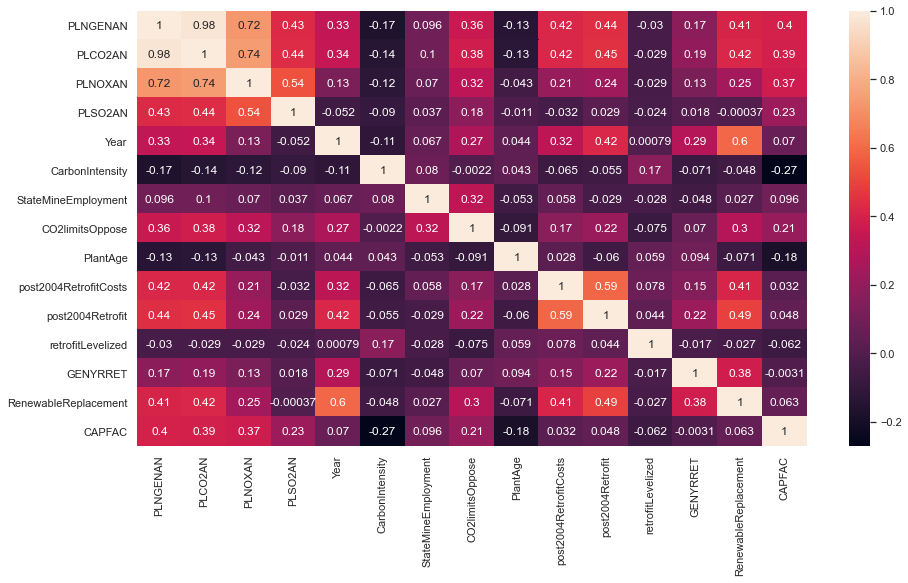

In [8]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,8)})

matrix = all[['PLNGENAN', 'PLCO2AN', 'PLNOXAN', 'PLSO2AN', 'Year', 'CarbonIntensity', 'StateMineEmployment', 'CO2limitsOppose', 'PlantAge', 'post2004RetrofitCosts', 'post2004Retrofit', 'retrofitLevelized', 'GENYRRET', 'RenewableReplacement', 'CAPFAC']].corr()

sns.heatmap(matrix, annot=True)
             
plt.show()


colorscale to use in kepler mapper visualizations: ranging from dark navy to red

In [9]:
my_colorscale = [[0.0, '#001219'],
             [0.1, '#005f73'],
             [0.2, '#0a9396'],
             [0.3, '#94d2bd'],
             [0.4, '#e9d8a6'],
             [0.5, '#ee9b00'],
             [0.6, '#ca6702'],
             [0.7, '#bb3e03'],
             [0.8, '#ae2012'],
             [0.9, '#9b2226'],
             [1.0, '#a50026']]  

Note that there is a function written into the coal_mapper class to create mapper simplicial complexes. This function is much more efficient, but does not create km.KeplerMapper objects or KeplerMapper.map objects to be used in subsectioning simplicial complexes.

As such, the full mapper simplicial complex code is used in each scenario so instances of these objects can be used to subsection plants into scenarios based on selecting nodes/groups from simplicial complexes

# full mapper and scenario 1 selection

viewing a mapper of exclusively decommissioned plants informs the scenario 1 selection. However, it is recomended to view a simplicial complex of all plants as well to inform the deciscion making used to infer that a graph of just decommissioned plants would suffice to inform scenario 1


In [ ]:
#map with 2 lenses
from sklearn import ensemble, cluster

def make_scn1():


    df = all
    df = df[df['decom']==1]
    df2 = StandardScaler().fit_transform(df[['PLNGENAN', 'PLSO2AN', 'CarbonIntensity', 'post2004RetrofitCosts', 'StateMineEmployment', 'CO2limitsOppose']])
    df3 = df[['PLNGENAN', 'PLCO2AN', 'PLNOXAN', 'PLSO2AN', 'decom', 'CarbonIntensity', 'StateMineEmployment', 'CO2limitsOppose', 'PlantAge', 'post2004RetrofitCosts', 'post2004Retrofit', 'retrofitLevelized', 'GENYRRET', 'RenewableReplacement', 'CAPFAC']]

    colors = df3
    labels = mapper_labels(df['label'])

    cubes = 10
    overlap = 0.4
    clusters = 2

    mapper = km.KeplerMapper(verbose=0)
    projector = ensemble.IsolationForest(random_state=0, n_jobs=-1)
    projector.fit(df2)
    lens3 = mapper.fit_transform(df2, projection=PCA(n_components=1))
    lens1 = projector.decision_function(df2)
    lens2 = mapper.fit_transform(df2, projection='knn_distance_5')
    lens = np.c_[lens1, lens2]

    graph_new = mapper.map(
        lens,
        df2,
        remove_duplicate_nodes=True,
        cover=km.Cover(n_cubes=cubes, perc_overlap=overlap),
        clusterer=cluster.AgglomerativeClustering(clusters))

    mapper.visualize(
        graph_new,
        path_html="decom_mapper.html",
        title="trial3' (" +str(cubes)+ " cubes at " +str(overlap*100) + "% overlap) with Plant Labels",
        custom_tooltips=labels,
        color_values = colors,
        colorscale=my_colorscale,
        color_function_name=list(df3.columns),
        node_color_function=['mean', 'median', 'max'],
        include_searchbar = True, 
        #include_intersection_selector= True
    )
    return graph_new, mapper

make_scn1()

In [10]:
scenario1df=all[all['decom'] == 0]
#### this cutoff of 658653 is the mean of the main cluster of decom plants
scenario1df = scenario1df[scenario1df['PLNGENAN']<658653]

# scenario 2 selection

In [13]:
#map with 2 lenses

from sklearn import ensemble, cluster

def make_scn2():
    df = all
    df = df[df['PLNGENAN']>658653]
    df = df[df['post2004RetrofitCosts']<400000000]

    df2 = StandardScaler().fit_transform(df[['PLNGENAN', 'PLSO2AN', 'CarbonIntensity', 'post2004RetrofitCosts', 'StateMineEmployment', 'CO2limitsOppose']])
    df3 = df[['PLNGENAN', 'PLCO2AN', 'PLNOXAN', 'PLSO2AN', 'decom', 'CarbonIntensity', 'StateMineEmployment', 'CO2limitsOppose', 'PlantAge', 'post2004RetrofitCosts', 'post2004Retrofit', 'retrofitLevelized', 'GENYRRET', 'RenewableReplacement', 'CAPFAC']]

    colors = df3
    labels = mapper_labels(df['label'])

    cubes = 9
    overlap = 0.25
    clusters = 2

    mapper = km.KeplerMapper(verbose=0)
    projector = ensemble.IsolationForest(random_state=0, n_jobs=-1)
    projector.fit(df2)
    lens3 = mapper.fit_transform(df2, projection=PCA(n_components=1))
    lens1 = projector.decision_function(df2)
    lens2 = mapper.fit_transform(df2, projection='knn_distance_5')
    lens = np.c_[lens1, lens2]

    graph_new = mapper.map(
        lens,
        df2,
        remove_duplicate_nodes=True,
        cover=km.Cover(n_cubes=cubes, perc_overlap=overlap),
        clusterer=cluster.AgglomerativeClustering(clusters))

    mapper.visualize(
        graph_new,
        path_html="scenario2_selection.html",
        title="trial3' (" +str(cubes)+ " cubes at " +str(overlap*100) + "% overlap) with Plant Labels",
        custom_tooltips=labels,
        color_values = colors,
        colorscale=my_colorscale,
        color_function_name=list(df3.columns),
        node_color_function=['mean', 'median', 'max'],
        include_searchbar = True, 
        #include_intersection_selector= True
    )

    return graph_new, mapper, labels

aaaaaa = make_scn2()
graph_new = aaaaaa[0]
mapper = aaaaaa[1]
labels = aaaaaa[2]


scenario 2 includes both active and retired plants, ensure removal of decommmissioned plants when analyzing active plants only and/or visualizing retirement scenarios

In [14]:
map2list = ['cube18_cluster0', 'cube17_cluster0', 'cube16_cluster0', 'cube9_cluster1', 'cube10_cluster0', 'cube9_cluster0', 'cube4_cluster0', 'cube10_cluster1', 'cube7_cluster1', 'cube13_cluster0', 'cube12_cluster0', 'cube11_cluster0', 'cube6_cluster0', 'cube5_cluster0', 'cube0_cluster0', 'cube0_cluster1']

bbb = list(graph_new['nodes'].keys())

decom2 = []
for x in bbb:
    # check if exists in unique_list or not
    if x not in map2list:
        decom2.append(x)

scenario2df = focusedDF(decom2)
scenario2INVERSEdf = focusedDF(map2list)

### create dataset of plants NOT selected in scenario 1 and 2

In [15]:
l1 = all[all['decom'] == 0]
l1 = l1[l1['PLNGENAN']<658653]
l1 = l1.append(scenario2df[scenario2df['decom']==0])

intrum = all[all['decom'] == 0]

def inverseDF (total, portion):
    eL = portion['label'].tolist()
    aL = total['label'].tolist()

    missing_list = []

    count = 0
    for x in aL:
        if x not in eL:
            count +=1
            missing_list.append(x)

    return focusMapper(missing_list, all)

l2 = inverseDF(intrum, l1)


# scenario 3 selection

In [22]:
#map with 2 lenses

def make_scn3():
    df = l2

    df2 = StandardScaler().fit_transform(df[['PLNGENAN', 'PLSO2AN', 'CarbonIntensity', 'post2004RetrofitCosts', 'StateMineEmployment', 'CO2limitsOppose']])
    df3 = df[['PLNGENAN', 'PLCO2AN', 'PLNOXAN', 'PLSO2AN', 'decom', 'CarbonIntensity', 'StateMineEmployment', 'CO2limitsOppose', 'PlantAge', 'post2004RetrofitCosts', 'post2004Retrofit', 'retrofitLevelized', 'GENYRRET', 'RenewableReplacement', 'CAPFAC']]

    colors = df3
    labels = mapper_labels(df['label'])

    cubes = 7
    overlap = 0.46
    clusters = 5

    mapper = km.KeplerMapper(verbose=0)
    projector = ensemble.IsolationForest(random_state=0, n_jobs=-1)
    projector.fit(df2)
    lens3 = mapper.fit_transform(df2, projection=PCA(n_components=1))
    lens1 = projector.decision_function(df2)
    lens2 = mapper.fit_transform(df2, projection='knn_distance_5')
    lens = np.c_[lens1, lens2]

    graph_new = mapper.map(
        lens,
        df2,
        remove_duplicate_nodes=True,
        cover=km.Cover(n_cubes=cubes, perc_overlap=overlap),
        clusterer=cluster.AgglomerativeClustering(clusters))

    mapper.visualize(
        graph_new,
        path_html="scenario3_selection.html",
        title="trial3' (" +str(cubes)+ " cubes at " +str(overlap*100) + "% overlap) with Plant Labels",
        custom_tooltips=labels,
        color_values = colors,
        colorscale=my_colorscale,
        color_function_name=list(df3.columns),
        node_color_function=['mean', 'median', 'max'],
        include_searchbar = True, 
        #include_intersection_selector= True
    )
    

    return graph_new, mapper, labels, df

aaaaaa = make_scn3()
graph_new = aaaaaa[0]
mapper = aaaaaa[1]
labels = aaaaaa[2]
df = aaaaaa[3]


In [23]:
aaa = list(graph_new['nodes'].keys())
exp2df = focusedDF(aaa)
print(len(df))
aL = df['label'].tolist()
eL = exp2df['label'].tolist()

missing_list = []

count = 0
for x in aL:
    if x not in eL:
        count +=1
        missing_list.append(x)

missing = focusMapper(missing_list, all)

print(len(missing))

63
2


In [24]:
map3list = ['cube16_cluster4', 'cube15_cluster3', 'cube15_cluster4', 'cube20_cluster1', 'cube19_cluster0', 'cube23_cluster3', 'cube22_cluster0', 'cube23_cluster1', 'cube20_cluster0', 'cube22_cluster3-cube23_cluster4', 'cube19_cluster2', 'cube15_cluster1', 'cube16_cluster1', 'cube17_cluster3', 'cube11_cluster0', 'cube12_cluster4', 'cube12_cluster2-cube17_cluster4', 'cube8_cluster0', 'cube8_cluster3', 'cube8_cluster4', 'cube12_cluster1', 'cube11_cluster2', 'cube16_cluster3', 'cube17_cluster1']

decom3 = []

bbb = list(graph_new['nodes'].keys())

for x in bbb:
    # check if exists in unique_list or not
    if x not in map3list:
        decom3.append(x)

scenario3df = focusedDF(decom3)
scenario4df = focusedDF(map3list)
scenario4df = scenario4df.append(missing)

# adding scenarios to full dataset

In [25]:
scenario1df['scenario'] = 1
scenario2df['scenario'] = 2
scenario2df = scenario2df[scenario2df['decom']==0]
scenario3df['scenario'] = 3

total = scenario1df.append(scenario2df)
total = total.append(scenario3df)

scenario4df['scenario'] = 4
total = total.append(scenario4df)

total = total.drop_duplicates(subset='ORISPL')

export to xlsx file – optional!

In [ ]:
#total.to_excel("total_scenario_creation.xlsx")

### create interactive scenario map

colorscaled to use in scenario maps

the plotting package did not allow for color rampos using the same scale, so multiple color scales were defined to ensure that scenarios remain the same color (ie. scenario 4 is always red and 2 is always blue) in maps of scenarios

In [26]:
chl_scale = [[0, "#4d8b9e"], 
              [1, "#4d8b9e"]]

colorscale1 = [[0, '#1c1b1b'], 
              [1, '#1c1b1b']]

colorscale2 = [[0, '#060606'],
             [1, '#4fb645']]

colorscale3 = [[0, '#060606'],
             [.5, '#4fb645'],
             [1, '#1335fc']]

colorscale4 = [[0, '#060606'],
             [.3, '#4fb645'],
             [.8, '#1335fc'],
             [1, '#fc3013']]

In [27]:
import plotly.graph_objects as go

#### change to change the scenarios displayed on the map
mapdf = total[total['scenario']<4]

#### make a second scattergeo with only scenario 1 to enlarge the points and increase map interpretability
mapdf2 = total[total['scenario'] == 1]


def make_chloropheth(subset:pd.DataFrame, all:pd.DataFrame):
    state_total = all[all['decom'] == 0].groupby('PSTATABB')['PLCO2AN'].sum().reset_index()
    state_reduction = subset[subset['decom'] == 0].groupby('PSTATABB')['PLCO2AN'].sum().reset_index()
    state_total = state_total.merge(state_reduction, how='left', on='PSTATABB').fillna(0)
    state_total['percentRedux'] = (state_total['PLCO2AN_y']/state_total['PLCO2AN_x'])*100
    return state_total
    
state_total = make_chloropheth(mapdf, all)

#### slight error with chloropleth coloring when viewing all scenarios, only displays a 99.99% CO2 reduction instead of 100

num = len(mapdf)
redux = int(100*(mapdf['PLCO2AN'].sum() / all[all['decom'] == 0]['PLCO2AN'].sum()))

fig = go.Figure(data=[
    go.Choropleth(
         locations=state_total['PSTATABB'], # Spatial coordinates
         z = state_total['percentRedux'].astype(float), # Data to be color-coded
         locationmode = 'USA-states', # set of locations match entries in `locations`
         colorscale = 'earth',
         colorbar_title = "% State Reduction"),

    go.Scattergeo(
            lon = mapdf['LON'],
            lat = mapdf['LAT'],
            text = mapdf['label'],
            #opacity = 0.9,
            showlegend = False,
            marker=dict(
                cauto=False,
                colorscale = colorscale3, #### change colorscale according to scenarios being mapped – colorscale3 corresponds to mapping scenario 1, 2, and 3
                size=mapdf['PLNGENAN']/700000
                ),

            marker_color = mapdf['scenario']),

    go.Scattergeo(
            lon = mapdf2['LON'],
            lat = mapdf2['LAT'],
            text = mapdf2['label'],
            #opacity = 0.8,
            showlegend = False,
            marker=dict(
                cauto=False,
                colorscale = colorscale1, #### keep this colorscale constant, mapping scenario 1 with larger points to increase readibility
                size=mapdf2['PLNGENAN']/200000,
                ),
            marker_color = mapdf2['scenario'])
        ])

fig.update_layout(
    
    title_text = f'{num} Plant Closures - {redux}% CO2 Reduction Nationwide',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [28]:
total.groupby('scenario')['PlantAge'].median()

scenario
1    48.000000
2    39.000000
3    41.803983
4    45.434888
Name: PlantAge, dtype: float64

In [29]:
total.groupby('scenario')['PLCO2AN', 'PLNOXAN', 'PLSO2AN', 'PlantAge', 'CAPFAC'].median()

<ipython-input-29-a26ee0e6881e>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,PLCO2AN,PLNOXAN,PLSO2AN,PlantAge,CAPFAC
scenario,,,,,
1,1.531355e+05,168.0865,222.366,48.000000,0.182385
2,2.710618e+06,1686.7870,2014.700,39.000000,0.353580
3,4.597600e+06,2229.5300,870.600,41.803983,0.317860
4,7.183206e+06,4581.1900,3714.250,45.434888,0.475980


In [30]:
#total[total['GENYRRET']>0].groupby('scenario')['GENYRRET'].count()
total[total['scenario']==4].count()

Year                     36
PSTATABB                 36
ORISPL                   36
LAT                      36
LON                      36
label                    36
CAPFAC                   36
PLNGENAN                 36
PLCO2AN                  36
PLNOXAN                  36
PLSO2AN                  36
decom                    36
CarbonIntensity          36
StateMineEmployment      36
CO2limits                36
CO2limitsOppose          36
fundrenewablesOppose     36
regulateOppose           36
reducetaxOppose          36
RenewableReplacement     36
%lessThanCoal            36
numGenerators            36
OperatingYear            36
PlantAge                 36
post2004Retrofit         36
post2004RetrofitCosts    36
retrofitLevelized        36
GENYRRET                 36
scenario                 36
index                    34
dtype: int64

array([[<AxesSubplot:title={'center':'PlantAge'}>]], dtype=object)

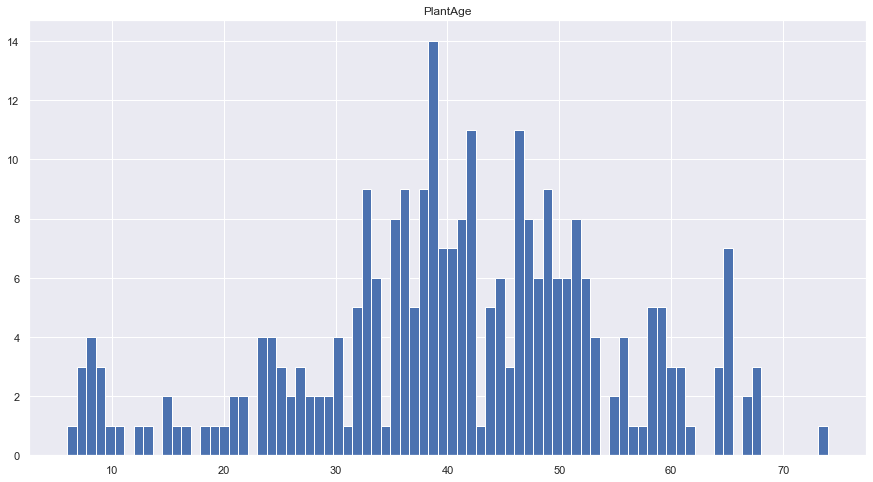

In [31]:
all[all['decom']==0].hist(column = 'PlantAge', bins = 80)

# DAC ADDITION

In [32]:
dac = pd.read_excel('power_plants_and_communities.xlsx')
dac = dac.rename(columns={"DOE/EIA ORIS plant or facility code": "ORISPL", "PM 2.5 Emssions (tons)": "PM_emissions"})
dac = dac[['ORISPL', 'total population (ACS2018)', 'National percentile for Demographic Index', 'PM_emissions', 'PM 2.5 Emission Rate (lb/MWh)']]
dac_all = total.merge(dac, how='left', left_on='ORISPL', right_on='ORISPL')

In [33]:
dac_all['affectedDAC'] = (dac_all['National percentile for Demographic Index']/100)*dac_all['total population (ACS2018)']
dac_all = dac_all.fillna(-1)

map = dac_all[dac_all['decom']==0]
map = map.fillna(-1)

In [34]:
dfc = dac_all[dac_all['decom']==0]
dfc.fillna(1)
dfc = dfc.replace(0, 1)

air_metric = (dfc['PLNOXAN'] + dfc['PLSO2AN'] + dfc['PM_emissions'])

dfc['air_metric'] = np.log(dfc['PLNOXAN'] + dfc['PLSO2AN'] + dfc['PM_emissions'])
dfc['pop_metric'] = np.log(dfc['total population (ACS2018)'])
dfc['dac_metric'] = np.log(dfc['National percentile for Demographic Index'])
dfc['perc_metric'] = np.log(dfc['affectedDAC'])

dfc['pm_metric'] = np.log(dfc['PM_emissions'])

dfc['pop_metric'] = (dfc['pop_metric']/(dfc['pop_metric'].mean()))*100
dfc['air_metric'] = (dfc['air_metric']/(dfc['air_metric'].mean()))*100
dfc['dac_metric'] = (dfc['dac_metric']/(dfc['dac_metric'].mean()))*100
dfc['perc_metric'] = (dfc['perc_metric']/(dfc['perc_metric'].mean()))*100
dfc['pm_metric'] = (dfc['pm_metric']/(dfc['pm_metric'].mean()))*100


dfc['pop_score'] = dfc['air_metric']*dfc['pop_metric']
dfc['DAC_score'] = dfc['air_metric']*dfc['dac_metric']
dfc['percDAC_score'] = dfc['air_metric']*dfc['perc_metric']



/Users/gathrid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

invalid value encountered in log



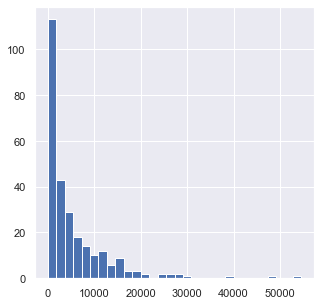

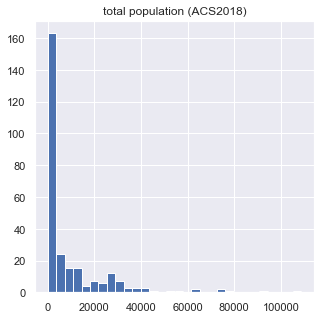

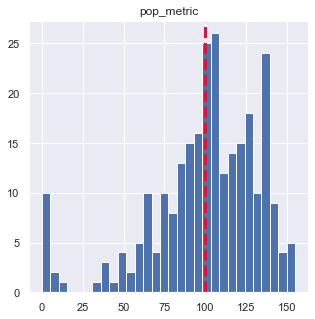

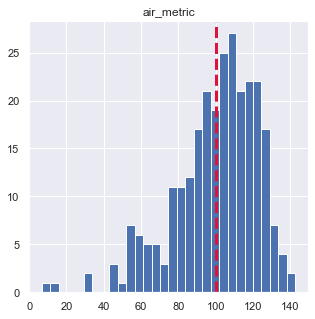

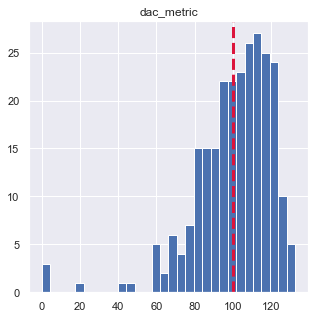

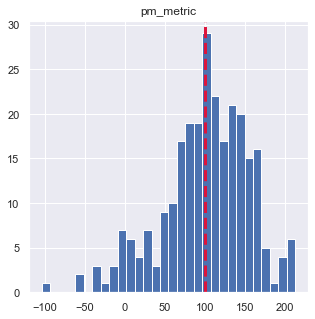

In [35]:
plt.figure(figsize=(5, 5))
plt.hist(x=air_metric, bins = 30)

dfc.hist(column='total population (ACS2018)', bins = 30, figsize=(5,5))

dfc.hist(column = 'pop_metric', figsize = (5,5), bins = 30)
plt.axvline(x=100, color = 'crimson', ls='--', lw = 3)

dfc.hist(column='air_metric', bins = 30, figsize = (5,5))
plt.axvline(x=100, color = 'crimson', ls='--', lw = 3)

dfc.hist(column='dac_metric', bins = 30, figsize = (5,5))
plt.axvline(x=100, color = 'crimson', ls='--', lw = 3)

dfc.hist(column='pm_metric', bins = 30, figsize = (5,5))
plt.axvline(x=100, color = 'crimson', ls='--', lw = 3)

<AxesSubplot:xlabel='National percentile for Demographic Index', ylabel='pop_score'>

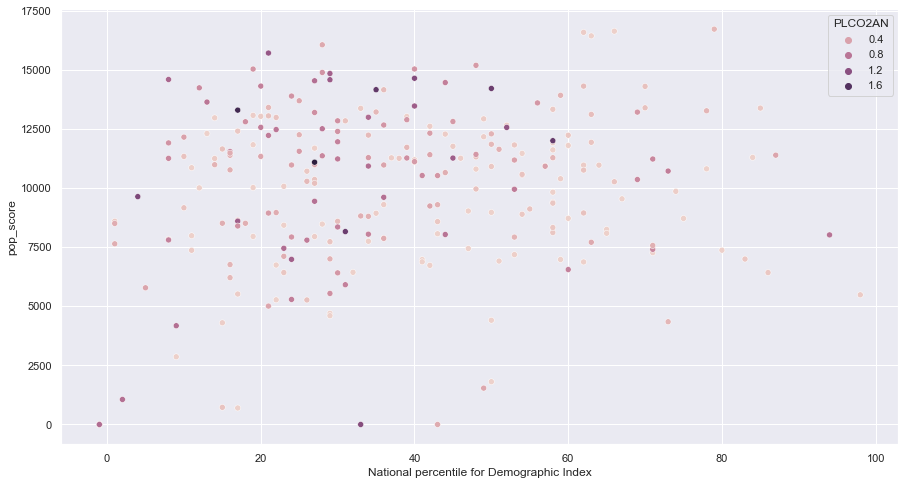

In [36]:
sns.scatterplot(x=dfc['National percentile for Demographic Index'], y = dfc['pop_score'], hue = dfc['PLCO2AN'])


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='National percentile for Demographic Index', ylabel='scenario'>

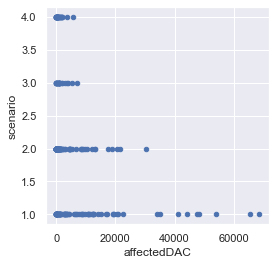

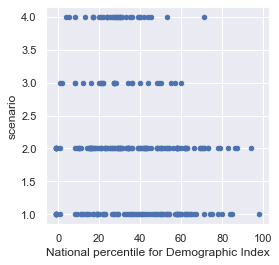

In [37]:
dfc.plot.scatter(x = 'affectedDAC', y = 'scenario', figsize = (4,4))

dfc.plot.scatter(x = 'National percentile for Demographic Index', y = 'scenario', figsize = (4,4))

# Individual Generators ADDITION

In [38]:
gen = pd.read_excel('egrid 2005-2020/egrid2020_data.xlsx', 'GEN20', header = 1).reset_index()

In [39]:
aL = gen['ORISPL'].tolist()
eL = dfc['ORISPL'].tolist()

gen_list = []
gen2 = gen
count = 0
for x in aL:
    if x in eL:
        count +=1
        gen_list.append(x)

gen2 = gen2[gen2['ORISPL'].isin(gen_list)]


In [40]:
dfc['ORISPL'] = dfc['ORISPL'].astype(int)

In [41]:
def removeNonCoal(gen2):
    gen2 = gen2[(gen2.FUELG1 != 'WND') & (gen2.FUELG1 != 'WDS') & (gen2.FUELG1 != 'WAT') & (gen2.FUELG1 != 'SUN') & (gen2.FUELG1 != 'RFO') & (gen2.FUELG1 != 'NG') & (gen2.FUELG1 != 'JF') & (gen2.FUELG1 != 'DFO') & (gen2.FUELG1 != 'NUC') & (gen2.FUELG1 != 'BLQ') ]
    return gen2

gen2 = removeNonCoal(gen2)

In [42]:
def p_ret(id):
    if id == 'RE':
        return 1

def ret(id):
    if id > 0:
        return 1
    else:
        return 0

gen2['numRetiredGenerators'] = gen2['GENSTAT'].apply(p_ret)



In [43]:
p_retDF = pd.DataFrame(gen2.groupby('ORISPL')['numRetiredGenerators'].sum())

In [44]:
genTotals = pd.DataFrame(gen2.groupby('ORISPL')['GENNTAN'].sum())
dfc2 = dfc.merge(genTotals, how='left', left_on='ORISPL', right_on='ORISPL')
dfc2 = dfc2.merge(p_retDF, how='left', left_on='ORISPL', right_on='ORISPL')
dfc2['PartiallyRetired'] = dfc2['numRetiredGenerators'].apply(ret)

dfc2 = dfc2[dfc2['GENNTAN'].notna()]

In [45]:
import plotly.express as px

px.scatter(data_frame=dfc2, x = dfc2['PLNGENAN'], y = dfc2['GENNTAN'], color = dfc2['numRetiredGenerators'], hover_name = dfc2['label'])

In [46]:
px.scatter(data_frame=dfc2, 
y = dfc2['pop_metric'], 
x = dfc2['air_metric'], 
color = dfc2['scenario'], 
hover_name = dfc2['label'])

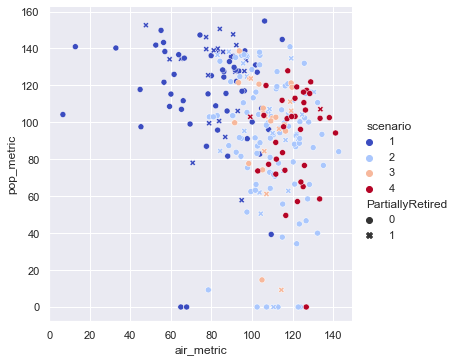

In [47]:


sns.relplot(y = dfc2['pop_metric'], x = dfc2['air_metric'], 
    hue = dfc2['scenario'], 
    palette='coolwarm',
    style = dfc2['PartiallyRetired'])
    

In [48]:
dfc2.groupby('scenario')['ORISPL'].sum()

scenario
1    1855108
2    1107309
3     138628
4     254365
Name: ORISPL, dtype: int64

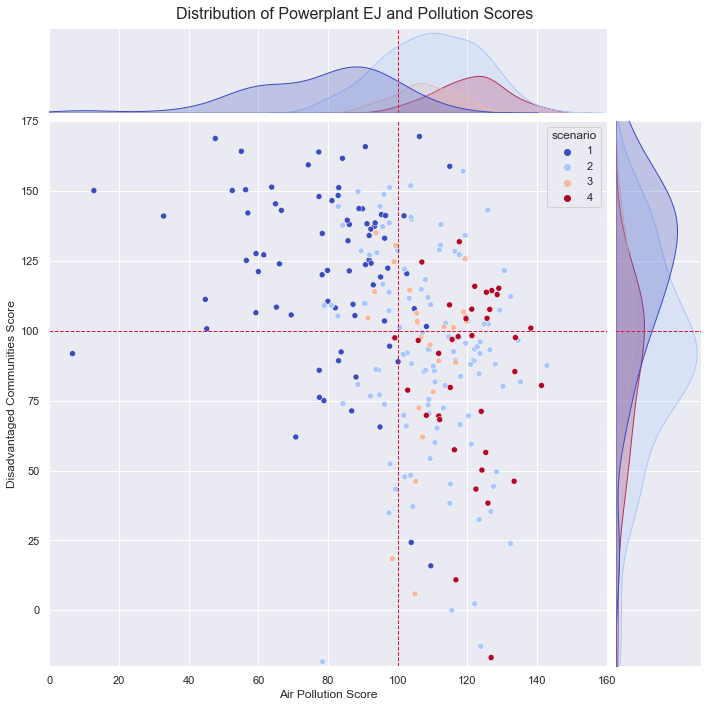

In [49]:
pt = sns.jointplot(
    y = dfc2['perc_metric'], 
    x = dfc2['air_metric'], 
    hue = dfc2['scenario'], 
    #size = dfc2['GENNTAN'],
    palette='coolwarm',
    xlim=(0,160),
    ylim=(-20,175),
    height=10, ratio = 6,space = 0.1) 


pt.ax_joint.axvline(x=100, color = 'crimson', ls='--', lw = 1)
pt.ax_marg_x.axvline(x=100, color = 'crimson', ls='--', lw = 1)

pt.ax_joint.axhline(y=100, color = 'crimson', ls='--', lw = 1)
pt.ax_marg_y.axhline(y=100, color = 'crimson', ls='--', lw = 1)

pt.fig.suptitle('Distribution of Powerplant EJ and Pollution Scores', size = 16)
pt.fig.subplots_adjust(top=.95)

pt.set_axis_labels('Air Pollution Score', 'Disadvantaged Communities Score', fontsize=12)

########pt.savefig('filename.png', dpi=300)

In [50]:
dfc2.groupby('scenario')['PartiallyRetired'].sum()/dfc2.groupby('scenario')['PartiallyRetired'].count()

scenario
1    0.265060
2    0.193277
3    0.346154
4    0.055556
Name: PartiallyRetired, dtype: float64

In [51]:
pret = dfc2
def plannedRet (id):
    if id > 1:
        return 1
    else:
        return 0

pret['plannedRet'] = pret['GENYRRET'].apply(plannedRet)

pret['affectedDAC'] = pret['affectedDAC'].replace(-1, 0)

In [52]:
import statsmodels.api as sm



# defining the dependent and independent variables
Xtrain = pret[['GENNTAN', 'air_metric',  'PartiallyRetired', 'affectedDAC', 'National percentile for Demographic Index', 'total population (ACS2018)']]
ytrain = pret[['plannedRet']]

# building the model and fitting the data
log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.607421
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             plannedRet   No. Observations:                  264
Model:                          Logit   Df Residuals:                      258
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Jul 2022   Pseudo R-squ.:                -0.01196
Time:                        12:53:46   Log-Likelihood:                -160.36
converged:                       True   LL-Null:                       -158.46
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
GENNTAN                                    1.0

# MAP CREATION

### retired plants trace

In [53]:
fig = go.Figure()

########
# Retired PLANTS
########
rdf = all[all['decom']==1]
fig.add_trace(go.Scattergeo(
    lon = rdf['LON'],
    lat = rdf['LAT'],
    text = rdf['label'],
    legendgroup="group",  # this can be any string, not just "group"
    legendgrouptitle_text="Retired Plants",
    name = 'Coal Plants Retired Since 2005',
    mode="markers",
    marker_symbol='circle',
    marker=dict(color="LightGrey", 
    line = dict(color = 'gray', width = 1),
    size=rdf['PLNGENAN']/600000)
))

########
# Scenario 1 PLANTS
########
s1df = dfc2[dfc2['scenario']==1]
s1df = s1df[s1df['PartiallyRetired']==0]
fig.add_trace(go.Scattergeo(
    lon = s1df['LON'],
    lat = s1df['LAT'],
    text = s1df['label'],
    legendgroup="group2",  # this can be any string, not just "group"
    legendgrouptitle_text="Scenario 1",
    name="Active",
    mode="markers",
    marker=dict(color="black", 
    line = dict(color = 'black', width = 1),
    size=s1df['GENNTAN']/600000)
))
p1df = dfc2[dfc2['scenario']==1]
p1df = p1df[p1df['PartiallyRetired']==1]
fig.add_trace(go.Scattergeo(
    lon = p1df['LON'],
    lat = p1df['LAT'],
    text = p1df['label'],
    legendgroup="group2",  # this can be any string, not just "group"
    legendgrouptitle_text="Scenario 1",
    name="Partially Decommissioned",
    mode="markers",
    marker_symbol='circle-open-dot',
    marker=dict(color="black", 
    line = dict(color = 'black', width = 1),
    size=s1df['GENNTAN']/600000)
))

########
# Scenario 2 PLANTS
########
s2df = dfc2[dfc2['scenario']==2]
s2df = s2df[s2df['PartiallyRetired']==0]
fig.add_trace(go.Scattergeo(
    lon = s2df['LON'],
    lat = s2df['LAT'],
    text = s2df['label'],
    legendgroup="group3",  # this can be any string, not just "group"
    legendgrouptitle_text="Scenario 2",
    name="Active",
    mode="markers",
    marker=dict(color="green", 
    line = dict(color = 'black', width = 1),
    size=s2df['GENNTAN']/600000)
))
p2df = dfc2[dfc2['scenario']==2]
p2df = p2df[p2df['PartiallyRetired']==1]
fig.add_trace(go.Scattergeo(
    lon = p2df['LON'],
    lat = p2df['LAT'],
    text = p2df['label'],
    legendgroup="group3",  # this can be any string, not just "group"
    legendgrouptitle_text="Scenario 2",
    name="Partially Decommissioned",
    mode="markers",
    marker_symbol='circle-open-dot',
    marker=dict(color="green", 
    line = dict(color = 'black', width = 1),
    size=s2df['GENNTAN']/600000)
))

########
# Scenario 3 PLANTS
########
s3df = dfc2[dfc2['scenario']==3]
s3df = s3df[s3df['PartiallyRetired']==0]
fig.add_trace(go.Scattergeo(
    lon = s3df['LON'],
    lat = s3df['LAT'],
    text = s3df['label'],
    legendgroup="group4",  # this can be any string, not just "group"
    legendgrouptitle_text="Scenario 3",
    name="Active",
    mode="markers",
    marker=dict(color="blue", 
    line = dict(color = 'black', width = 1),
    size=s3df['GENNTAN']/600000)
))
p3df = dfc2[dfc2['scenario']==3]
p3df = p3df[p3df['PartiallyRetired']==1]
fig.add_trace(go.Scattergeo(
    lon = p3df['LON'],
    lat = p3df['LAT'],
    text = p3df['label'],
    legendgroup="group4",  # this can be any string, not just "group"
    legendgrouptitle_text="Scenario 3",
    name="Partially Decommissioned",
    mode="markers",
    marker_symbol='circle-open-dot',
    marker=dict(color="blue", 
    line = dict(color = 'black', width = 1),
    size=s3df['GENNTAN']/600000)
))

########
# Scenario 4 PLANTS
########
s4df = dfc2[dfc2['scenario']==4]
s4df = s4df[s4df['PartiallyRetired']==0]
fig.add_trace(go.Scattergeo(
    lon = s4df['LON'],
    lat = s4df['LAT'],
    text = s4df['label'],
    legendgroup="group5",  # this can be any string, not just "group"
    legendgrouptitle_text="Scenario 4",
    name="Active",
    mode="markers",
    marker=dict(color="red", 
    line = dict(color = 'black', width = 1),
    size=s4df['GENNTAN']/600000)
))

p4df = dfc2[dfc2['scenario']==4]
p4df = p4df[p4df['PartiallyRetired']==1]
fig.add_trace(go.Scattergeo(
    lon = p4df['LON'],
    lat = p4df['LAT'],
    text = p4df['label'],
    legendgroup="group5",
    legendgrouptitle_text="Scenario 4",
    name="Partially Decommissioned",
    mode="markers",
    marker_symbol='circle-open-dot',
    marker=dict(color="red",
    line = dict(color = 'black', width = 1),
    size=s4df['GENNTAN']/600000)
))


########
# MAKE MAP
########

fig.update_layout(
    width=1400,
    height = 700,
    title_text = f'{num} Plant Closures - {redux}% CO2 Reduction Nationwide',
    geo_scope='usa', # limite map scope to USA,
    legend=dict(groupclick='toggleitem', itemdoubleclick = 'toggleothers')
)

fig.show()

In [ ]:
dfc2['PartiallyRetired'].sum()